# Testing of queue imbalance for company 9091

Order of this notebook is as follows:
1. [Data preparation](#Data-preparation)
2. [Data visualization](#Data-visualization)
3. [Tests](#Tests)
4. [Conclusions](#Conclusions)

Goal is to implement queue imbalance predictor from [1](#Resources).

In [1]:
%matplotlib inline
import pandas as pd

from typing import Tuple
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import numpy as np
import lob

import warnings

warnings.filterwarnings('ignore')

## Data preparation

The data seems to be from small-tick market.

### Train data

For training data we used data from 2013-09 - 2013-10:

* 0901
* 0916
* 1001
* 1016

### Test data

For testing data we used data from first half of 2013-11

* 1101

In [2]:
df, df_test = lob.load_data('9061')
df.head()

Training set length: 13793
Testing set length: 3448


,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2013-10-29 11:28:00,"[(550.0, 6364.0), (580.0, 32600.0), (600.0, 41...","[(689.1, 3324.0), (689.2, 6497.0), (689.3, 771...",689.0,689.1,689.05,3324.0,1427.0,1.0,-0.399284
2013-10-17 10:09:00,"[(550.0, 6364.0), (580.0, 2600.0), (600.0, 246...","[(677.8, 11045.0), (677.9, 20025.0), (678.0, 1...",677.6,677.8,677.70,11045.0,2297.0,1.0,-0.655674
2013-09-16 12:03:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(704.8, 3857.0), (704.9, 10513.0), (705.0, 94...",704.7,704.8,704.75,3857.0,1300.0,1.0,-0.495831
2013-10-18 12:55:00,"[(550.0, 6364.0), (580.0, 32600.0), (600.0, 41...","[(676.0, 2431.0), (676.1, 15893.0), (676.2, 17...",675.9,676.0,675.95,2431.0,5801.0,0.0,0.409378
2013-09-16 14:32:00,"[(550.0, 6364.0), (600.0, 1400.0), (615.0, 273...","[(704.2, 8443.0), (704.3, 15439.0), (704.4, 13...",703.9,704.2,704.05,8443.0,9001.0,1.0,0.031988


## Data visualization

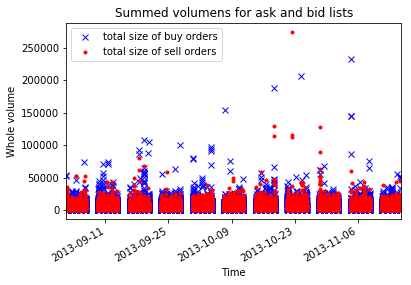

In [3]:
df['sum_buy_bid'].plot(label='total size of buy orders', style='bx')
df['sum_sell_ask'].plot(label='total size of sell orders', style='r.')
plt.title('Summed volumens for ask and bid lists')
plt.xlabel('Time')
plt.ylabel('Whole volume')
plt.legend()

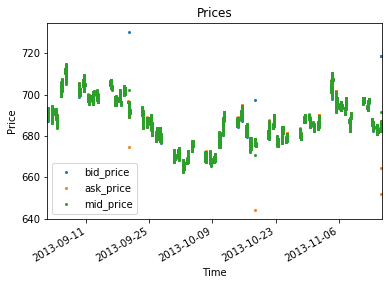

In [4]:
df[['bid_price', 'ask_price', 'mid_price']].plot(style='o', ms=2)
plt.legend()
plt.title('Prices')
plt.xlabel('Time')
plt.ylabel('Price')

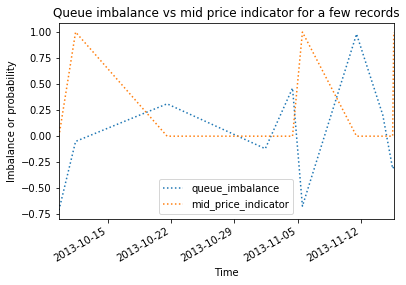

In [5]:
df.iloc[10:20][['queue_imbalance', 'mid_price_indicator']].plot(style=':')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Imbalance or probability')
plt.title('Queue imbalance vs mid price indicator for a few records')

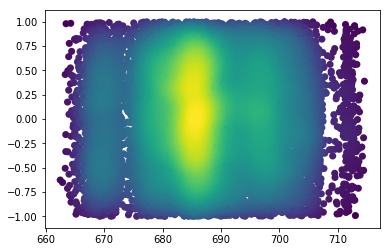

In [6]:
lob.plot_density_imbalance_vs_mid(df, 0, len(df))

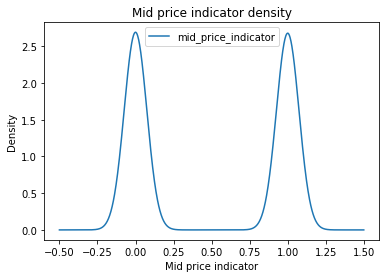

In [7]:
df['mid_price_indicator'].plot('kde')
plt.legend()
plt.xlabel('Mid price indicator')
plt.title('Mid price indicator density')

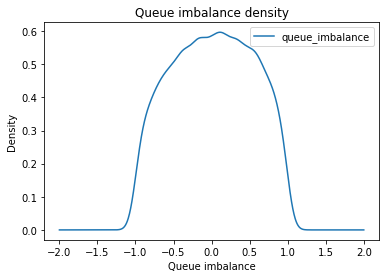

In [8]:
df['queue_imbalance'].plot('kde')
plt.legend()
plt.xlabel('Queue imbalance')
plt.title('Queue imbalance density')

## Tests

We use logistic regression to predict `mid_price_indicator`.
We calculate 2 types of errors:

* mean square error between predictions and actual values
* mean square error between (square error of null prediction, square error of predicition)

[ 1.  0.  1. ...,  1.  0.  1.]
[0.002780075387496043, 0.24743441174049122, 0.25, 0.45910672853828305, 0.25]


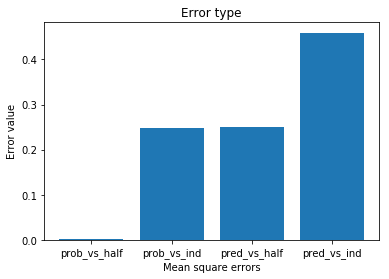

In [9]:
reg = lob.logistic_regression(df, 0, len(df))

probabilities = reg.predict_proba(df_test['queue_imbalance'].values.reshape(-1,1))
probabilities = [p1 for p0, p1 in probabilities]
prob_vs_half = ((0.5 * np.ones(len(probabilities)) - probabilities) ** 2).mean()
prob_vs_ind = ((df_test['mid_price_indicator'] - probabilities) ** 2).mean()

predictions = reg.predict(df_test['queue_imbalance'].values.reshape(-1, 1))
print(predictions)
pred_vs_half = ((0.5 * np.ones(len(predictions)) - predictions) ** 2).mean()
pred_vs_ind = ((df_test['mid_price_indicator'] - predictions) ** 2).mean()
nul = ((df_test['mid_price_indicator'] - (0.5 * np.ones(len(predictions)))) ** 2).mean()


plt.bar(np.arange(4), [prob_vs_half, prob_vs_ind, pred_vs_half, pred_vs_ind])
plt.xticks(np.arange(4), ['prob_vs_half', 'prob_vs_ind', 'pred_vs_half', 'pred_vs_ind'])
plt.xlabel('Mean square errors')
plt.ylabel('Error value')
plt.title('Error type')
print([prob_vs_half, prob_vs_ind, pred_vs_half, pred_vs_ind, nul])

In [10]:
h = ((0.5 * np.ones(len(probabilities)) - df_test['mid_price_indicator']) ** 2).mean()
p= ((df_test['mid_price_indicator'] - predictions) ** 2).mean()

#print(((h-p) ** 2).mean())
print((h-p)**2)

0.0437256239199832


2759
2776


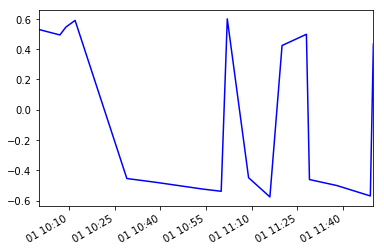

In [11]:
st = df_test.index.get_loc('2013-11-01 10H').start
print(st)
end = df_test.index.get_loc('2013-11-01 11H').stop
print(end)
(df_test['mid_price_indicator'].iloc[st:end] - probabilities[st:end]).plot(style='b')

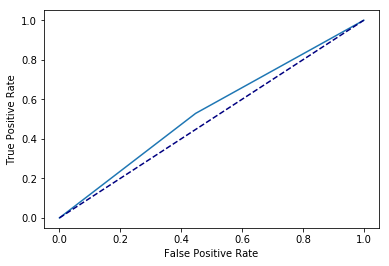

In [12]:
from sklearn.metrics import roc_curve, auc


a, b, c = roc_curve(df_test['mid_price_indicator'], predictions)
plt.plot(a, b)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

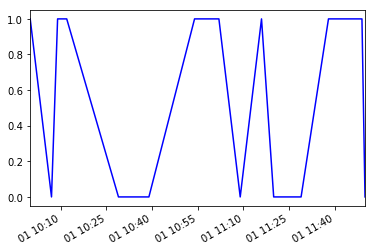

In [13]:
((df_test['mid_price_indicator'].iloc[st:end] - predictions[st:end])**2).plot(style='b')

2759
2776


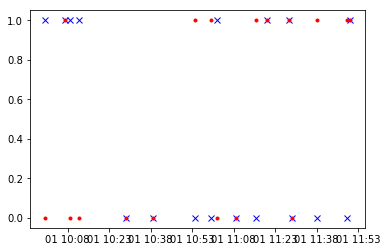

In [14]:
st = df_test.index.get_loc('2013-11-01 10H').start
print(st)
end = df_test.index.get_loc('2013-11-01 11H').stop
print(end)

plt.plot(df_test['mid_price_indicator'].iloc[st:end], 'bx')
plt.plot(df_test.index[st:end], predictions[st:end], 'r.')

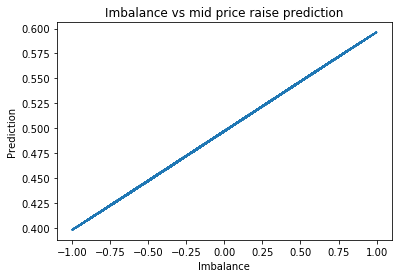

In [15]:
plt.plot(df_test['queue_imbalance'].values, 
         lob.sigmoid(reg.coef_[0] * df_test['queue_imbalance'].values + reg.intercept_))
plt.title('Imbalance vs mid price raise prediction')
plt.xlabel('Imbalance')
plt.ylabel('Prediction')

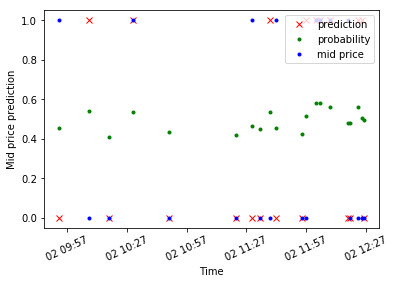

In [16]:
st = 10
end = 30

plt.plot(df_test.index[st:end], predictions[st:end], 'rx', label='prediction')
plt.plot(df_test.index[st:end], probabilities[st:end], 'g.', label='probability')
plt.plot(df_test.index[st:end], df_test['mid_price_indicator'].values[st:end], 'b.', label='mid price')
plt.xticks(rotation=25)
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Mid price prediction')

## Conclusions

Looking at mid_price_indicator density plot it seems that bid and ask queues are balanced. The same conclusion we can get from queue imbalance density plot - it looks like normal distribution: most often the queues are balanced.

Errors:

* predicted probability vs null model: 0.00040
* predicted probability vs known indicator: 0.2495
* prediction vs null model: 0.25
* prediction vs known indicator: 0.47578

Probabilistic classification works about 25% better than null model. Its values are between 0.45-0.54, which is the reason of why mean square error between probabilistic predictions and null model is small (0.0004). 
Binary classification works about 3.5% better than null model.

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a> 